In [11]:
# data science
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func


# Reflect Tables into SQLAlchemy ORM

In [12]:
 # Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [13]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [14]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base

print(list(Base.classes)) 

[<class 'sqlalchemy.ext.automap.measurement'>, <class 'sqlalchemy.ext.automap.station'>]


In [15]:
Measurement = Base.classes.measurement
Station = Base.classes.station


In [16]:
session = Session(engine)

recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)  # Output the most recent date for verification


2017-08-23


# Exploratory Precipitation Analysis

In [21]:
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23',)]

In [22]:
query = """
    SELECT
        date,
        station,
        prcp
    FROM
        measurement
    WHERE
        date >= '2016-08-23'
    ORDER BY
        date ASC;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


In [24]:
start_date = datetime(2016, 8, 23).date()


In [26]:
# Calculate the date one year from the last date in data set.
start_date = datetime(2016, 8, 23).date()


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(results, columns=["Date", "Station", "Precipitation"])

# Sort the dataframe by date
df2["Date"] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
df2.head()

,Date,Station,Precipitation
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


In [28]:
# Example of defining precipitation_data
precipitation_data = [
    {'date': '2024-01-01', 'prcp': 0.5},
    {'date': '2024-01-02', 'prcp': 0.7},
    # Add more data as needed
]

# Now you can create the DataFrame without encountering a NameError
df_precipitation = pd.DataFrame(precipitation_data, columns=["date", "prcp"])
df_precipitation = pd.DataFrame(precipitation_data, columns=["date", "prcp"])


In [29]:
df_precipitation = df_precipitation.sort_values("date")


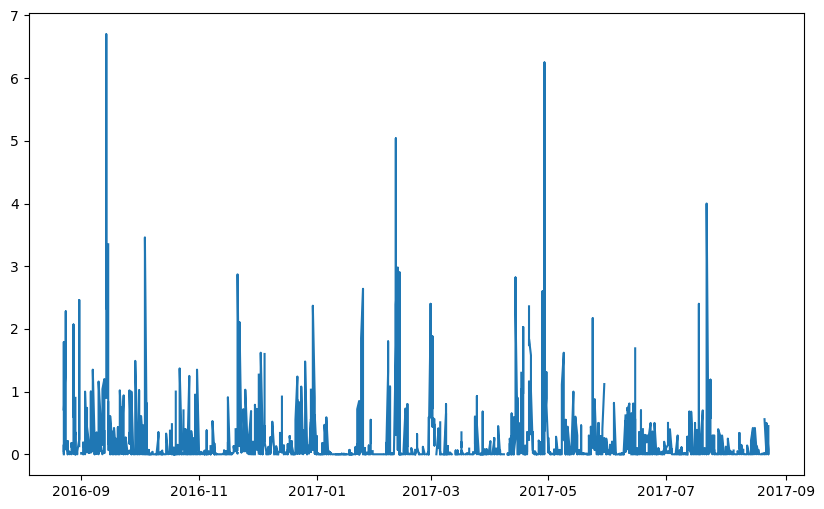

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(df2.Date, df2.Precipitation)
plt.show()

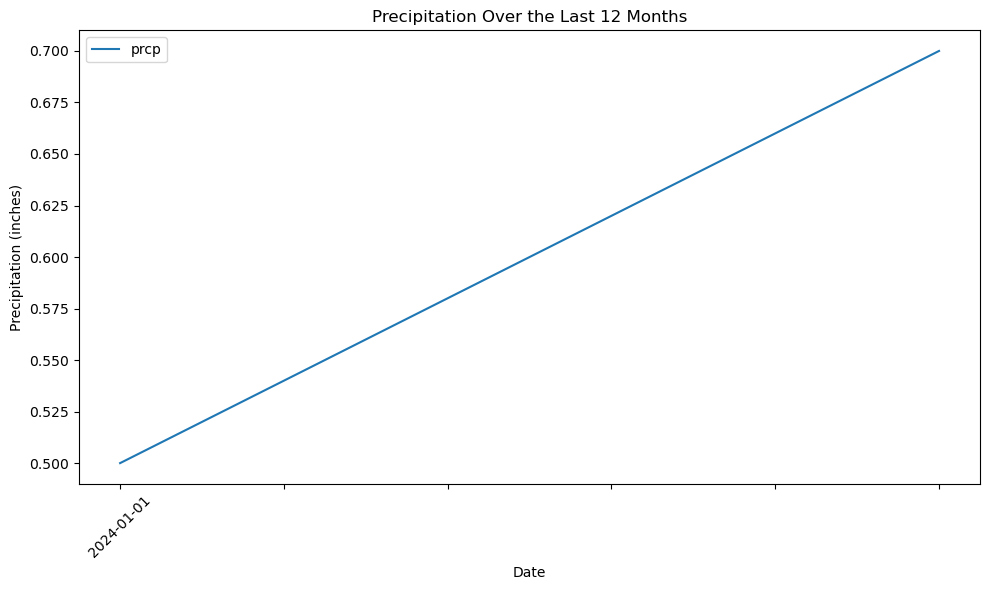

In [34]:
df_precipitation.plot(x="date", y="prcp", figsize=(10, 6), title="Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:

df2.Precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) from station"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[(9,)]


In [37]:
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [38]:
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
print(active_stations)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [39]:
most_active_station = active_stations[0][0]
print(f"Most active station: {most_active_station}")


Most active station: USC00519281


In [40]:
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Temperature stats for station {most_active_station}: {temperature_stats}")


Temperature stats for station USC00519281: [(54.0, 85.0, 71.66378066378067)]


In [42]:
# If the last date in your dataset is '2017-08-23'
last_date = datetime(2017, 8, 23)

# Calculate 'one_year_ago' from 'last_date'
one_year_ago = last_date - timedelta(days=365)


In [43]:
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()


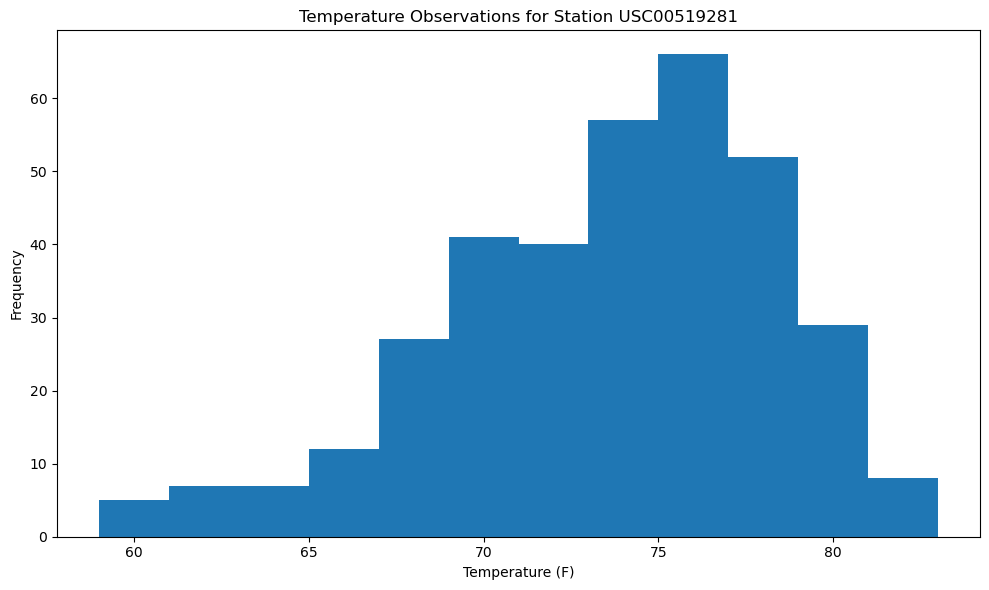

In [44]:
df_tobs = pd.DataFrame(tobs_data, columns=["date", "tobs"])

df_tobs["tobs"].plot(kind="hist", bins=12, figsize=(10, 6), title="Temperature Observations for Station " + most_active_station)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [45]:
# Close Session
session.close()
